In [1]:
import os
import sys
import glob
import torch
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter

sys.path.insert(0, os.path.expanduser('./yield-forecast-torch'))

ModuleNotFoundError: No module named 'torch'

In [2]:
from yieldforecast.data import make_input
from yieldforecast.model import YieldModule
from yieldforecast.train import train, nll_loss, combined_loss

In [3]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

plt.style.use('bmh')
plt.rc('font',**{'family':'sans-serif','sans-serif':['', 'Arial', 'Helvetica']})
font = {'family' : 'Liberation Sans',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=False)

In [4]:
TIMESTEPS = {
    'brazil': {
        'rice': range(1, 9),
        'corn': range(1, 10),
        'cotton': range(1, 10),
        'soybean': range(1, 10),
        'sugarcane': range(1, 13),
    }
}
TIMESTEPS.update({
    k: {'soybean': range(5, 11)} for k in (
            'illinois iowa minnesota ohio nebraska indiana us '
            'north_dakota missouri south_dakota arkansas'
        ).split()
})

In [5]:
import numpy as np
import pandas as pd
import torch.utils.data as tdata

from pprint import pprint
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score

BU_ACRE_TO_METRIC_TONNES = 67.25106937166726

METRICS = {
    'R2': r2_score,
    'MAE': mean_absolute_error,
    'MSE': mean_squared_error,
    'MAPE': lambda x, y: mean_absolute_percentage_error(x, y),
    'Correlation': lambda x, y: np.corrcoef(x, y)[0][1],
}


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def get_error_metrics(df):
    return {name: metric(df['test'], df['pred']) for name, metric in METRICS.items()}

def evaluate(model, inputs, y, scaler, batch_size=512, device='cuda'):
    dynamic, static = inputs
    if not isinstance(dynamic, torch.Tensor):
        dynamic = torch.from_numpy(dynamic)

    if not isinstance(static, torch.Tensor):
        static = torch.from_numpy(static)

    dataset = tdata.TensorDataset(
        dynamic, static
    )

    dataloader = tdata.DataLoader(
        dataset, batch_size=batch_size
    )

    pred = []
    with torch.no_grad():
        for dyn, stat in dataloader:
            pred.append(model(dyn.to(device), stat.to(device)))
    std = np.hstack([p.stddev.detach().cpu().numpy().reshape((-1,)) for p in pred]).squeeze().reshape((-1, 1))
    pred = np.hstack([p.mean.detach().cpu().numpy().reshape((-1,)) for p in pred]).squeeze().reshape((-1, 1))

    df = pd.DataFrame(
        {
            'pred': scaler.inverse_transform(pred).reshape((-1,)),
            'test': scaler.inverse_transform(y).reshape((-1,)),
            'std': scaler.inverse_transform(std).reshape((-1,)),
        },
        index=range(len(pred))
    ) * BU_ACRE_TO_METRIC_TONNES

    try:
        metrics = get_error_metrics(df)
        pprint(metrics)
    except ValueError:
        logger.exception(
            'Failed to evaluate model. Probably with ∞ or NaN in network output.'
        )
        return None

    return df

In [6]:
from scipy.stats import norm
from scipy.special import gdtrix

def plot_reliability(df, crop, scaler, step=0.01):
    x = np.arange(0, 1. + step, step)

    pj_test = []
    for alpha in x:
        # alpha = 0.95
        # (1 - alpha) / 2 <-> (1 - alpha/2)
        bottom = norm.ppf(q=(1 - alpha) / 2, loc=df['pred'], scale=df['std'])
        top = norm.ppf(q=1 - (1 - alpha) / 2, loc=df['pred'], scale=df['std'])
        pj_test.append(
            ((df['test'] <= top) & (df['test'] >= bottom)).mean()
        )

    plt.figure(figsize=(8.0, 8.0))
    plt.plot(x, pj_test, label='Computed')
    plt.plot(x, x, '--', label='Ideal')
    plt.xlabel('Expected confidence level')
    plt.ylabel('Observed confidence level')
    plt.title(f'Reliability plot for {crop}')
    plt.legend()
    plt.tight_layout(pad=.1)
    plt.savefig(f'reliability-{crop}.pdf')

def plot_scatter(df, crop, scaler):
    fig = plt.figure(figsize=(8.0, 8.0))
    plt.scatter(df['test'], df['pred'], c=df['std'])
    c = plt.colorbar(orientation='horizontal')
    h = c.ax.set_xlabel("Uncertainty")
    c.ax.get_xaxis().set_ticks([])
    for j, label in enumerate('low medium high'.split()):
        c.ax.text(
            (2 * j + 1) / 6, .5, label, va='center', ha='center',
            color='white' if j != 1 else 'black', transform=c.ax.transAxes
        )

    y_lim = plt.ylim()
    x_lim = plt.xlim()
    lim = max(x_lim, y_lim)
    locs, vals = plt.xticks()
    plt.yticks(locs, vals)
    plt.plot(lim, lim, 'k-')
    plt.ylim(lim)
    plt.xlim(lim)
    plt.xlabel('Actual (kg/ha)')
    plt.ylabel('Predicted (kg/ha)')
    ax = plt.gca()
    ax.yaxis.set_major_formatter(
        mpl.ticker.ScalarFormatter(useMathText=True)
    )
    ax.xaxis.set_major_formatter(
        mpl.ticker.ScalarFormatter(useMathText=True)
    )
    ax.ticklabel_format(axis='both', style='sci', scilimits=(-2, 2))
    plt.tight_layout(pad=.1)
    plt.savefig(f'uncertainty-{region}-{crop}.pdf')

In [7]:
def next_run(crop, region):
    runs = glob.glob(f'runs/{region}-{crop}*')
    return len(runs) + 1

In [1]:
crop = 'corn'
region = 'brazil'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
path = (Path(os.path.expanduser('./yield-forecast-torch/data')) / f'{region}-{crop}-input.csv').absolute()
data = make_input(path, 'out', use_ndvi=False, timesteps=TIMESTEPS[region][crop],
                  use_all_soilgrids_layers=False, year=2018)

NameError: name 'torch' is not defined

In [9]:
checkpoint_template = f'{region}-{crop}-%s-weights.pth'

In [10]:
import logging
logging.basicConfig(level=logging.INFO)

In [11]:
device

'cuda'

In [12]:
def loss(target, dist):
    return nll_loss(target, dist) - 1e-1 * dist.entropy().mean()

In [15]:
import optuna

def objective(trial):
    entropy = trial.suggest_uniform('entropy', 0, .5)
    #α = trial.suggest_loguniform('α', 1e-7, 1e-4)
    noise = trial.suggest_uniform('noise', 0, 0.2)
    #gamma = trial.suggest_uniform('gamma', 0, .9)
    α = 5e-4

    def current_loss(target, dist):
        return nll_loss(target, dist) - entropy * dist.entropy().mean()

    model = YieldModule().to(device)
    train(
        model, data['X_train'], data['y_train'], data['train_years'],
        α=α, patience=25, epochs=1000, device=device, noise=noise, writer=None,
        checkpoint_template=checkpoint_template, step_size=512, gamma=.5,
        loss=current_loss
    )
    model.load_state_dict(torch.load(f'{region}-{crop}-best-weights.pth'))
    df = evaluate(model, data['X_test'], data['y_test'], data['y_scaler'])
    return -np.corrcoef(df.pred, df.test)[0, 1]

In [16]:
try:
    study = optuna.create_study(study_name='corn', storage='sqlite:///studies.db')
except:
    study = optuna.load_study(study_name='corn', storage='sqlite:///studies.db')
study.optimize(objective, n_trials=66)

INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.843E-01 ± 1.796E-01, valid loss: -5.489E-01 ± 9.714E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.835E-01 ± 7.320E-02, valid loss: -6.265E-01 ± 6.247E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -6.255E-01 ± 7.654E-02, valid loss: -6.664E-01 ± 6.324E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.478E-01 ± 7.413E-02, valid loss: -6.283E-01 ± 3.176E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.626E-01 ± 7.485E-02, valid loss: -5.922E-01 ± 2.749E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.729E-01 ± 6.995E-02, valid loss: -6.592E-01 ± 6.600E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.816E-01 ± 7.136E-02, valid loss: -7.379E-01 ± 6.125E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.978E-01 ± 7.831E-02, valid loss: -6.786E-01 ± 6.958E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9109918468288453,
 'MAE': 792.93774,
 'MAPE': 47.085750102996826,
 'MSE': 1292540.5,
 'R2': 0.8193809545558355}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.036E-01 ± 1.429E-01, valid loss: -4.758E-01 ± 4.737E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -4.869E-01 ± 5.359E-02, valid loss: -5.235E-01 ± 4.945E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.284E-01 ± 5.268E-02, valid loss: -5.616E-01 ± 3.758E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.441E-01 ± 5.639E-02, valid loss: -5.661E-01 ± 5.980E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.502E-01 ± 6.650E-02, valid loss: -5.737E-01 ± 4.056E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -5.669E-01 ± 5.992E-02, valid loss: -5.478E-01 ± 6.722E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -5.762E-01 ± 5.494E-02, valid loss: -5.851E-01 ± 3.502E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -5.806E-01 ± 5.817E-02, valid loss: -5.530E-01 ± 3.471E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8952747111668031,
 'MAE': 848.29034,
 'MAPE': 58.58578681945801,
 'MSE': 1459744.5,
 'R2': 0.7960159496034123}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.204E-01 ± 1.348E-01, valid loss: -4.549E-01 ± 3.761E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -4.992E-01 ± 5.141E-02, valid loss: -5.425E-01 ± 7.112E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.295E-01 ± 5.224E-02, valid loss: -5.354E-01 ± 4.865E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.471E-01 ± 5.381E-02, valid loss: -5.460E-01 ± 4.286E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.458E-01 ± 6.607E-02, valid loss: -5.749E-01 ± 6.214E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -5.500E-01 ± 7.259E-02, valid loss: -5.747E-01 ± 4.260E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -5.656E-01 ± 5.116E-02, valid loss: -5.613E-01 ± 6.561E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -5.622E-01 ± 6.496E-02, valid loss: -5.841E-01 ± 6.577E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9143439061315815,
 'MAE': 767.58575,
 'MAPE': 43.434327840805054,
 'MSE': 1206528.1,
 'R2': 0.8314002921610121}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.179E-01 ± 1.166E-01, valid loss: -4.805E-01 ± 6.192E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -4.994E-01 ± 5.870E-02, valid loss: -5.341E-01 ± 4.649E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.248E-01 ± 5.367E-02, valid loss: -5.519E-01 ± 4.144E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.468E-01 ± 5.983E-02, valid loss: -5.466E-01 ± 7.585E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.580E-01 ± 5.672E-02, valid loss: -5.694E-01 ± 4.338E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -5.662E-01 ± 5.232E-02, valid loss: -5.730E-01 ± 4.975E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -5.741E-01 ± 5.536E-02, valid loss: -5.676E-01 ± 5.929E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -5.753E-01 ± 5.807E-02, valid loss: -5.821E-01 ± 3.376E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8798548495598605,
 'MAE': 899.49554,
 'MAPE': 47.469013929367065,
 'MSE': 1653734.6,
 'R2': 0.7689078479035775}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -5.173E-01 ± 2.110E-01, valid loss: -6.340E-01 ± 7.980E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -6.546E-01 ± 6.887E-02, valid loss: -6.832E-01 ± 6.498E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -7.029E-01 ± 8.204E-02, valid loss: -7.104E-01 ± 7.683E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -7.242E-01 ± 8.961E-02, valid loss: -7.267E-01 ± 5.073E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -7.245E-01 ± 9.048E-02, valid loss: -7.744E-01 ± 5.815E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -7.464E-01 ± 7.875E-02, valid loss: -8.042E-01 ± 7.402E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -7.638E-01 ± 8.715E-02, valid loss: -7.496E-01 ± 7.328E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -7.812E-01 ± 7.545E-02, valid loss: -7.630E-01 ± 6.506E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8776287262553092,
 'MAE': 914.21436,
 'MAPE': 52.557188272476196,
 'MSE': 1699842.0,
 'R2': 0.7624648310673577}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.124E-01 ± 9.742E-02, valid loss: -4.521E-01 ± 4.534E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -4.850E-01 ± 4.302E-02, valid loss: -4.963E-01 ± 4.596E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.012E-01 ± 5.362E-02, valid loss: -4.947E-01 ± 7.537E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.207E-01 ± 5.264E-02, valid loss: -5.142E-01 ± 9.340E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.284E-01 ± 5.203E-02, valid loss: -5.563E-01 ± 5.069E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -5.411E-01 ± 5.996E-02, valid loss: -5.345E-01 ± 2.542E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -5.474E-01 ± 5.429E-02, valid loss: -5.579E-01 ± 3.554E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -5.439E-01 ± 5.500E-02, valid loss: -5.532E-01 ± 6.626E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8916078329131865,
 'MAE': 862.8053,
 'MAPE': 49.926066398620605,
 'MSE': 1532379.1,
 'R2': 0.7858660156205975}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.350E-01 ± 1.338E-01, valid loss: -4.875E-01 ± 3.210E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.143E-01 ± 5.914E-02, valid loss: -5.340E-01 ± 4.908E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.516E-01 ± 6.026E-02, valid loss: -5.872E-01 ± 5.399E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.732E-01 ± 6.373E-02, valid loss: -5.707E-01 ± 4.992E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.871E-01 ± 5.518E-02, valid loss: -5.780E-01 ± 5.929E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -5.921E-01 ± 6.091E-02, valid loss: -6.028E-01 ± 1.274E-01 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.020E-01 ± 5.839E-02, valid loss: -5.927E-01 ± 4.559E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.030E-01 ± 6.476E-02, valid loss: -5.946E-01 ± 6.486E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9139930012932286,
 'MAE': 768.0143,
 'MAPE': 44.15536820888519,
 'MSE': 1243863.5,
 'R2': 0.8261830773302532}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -5.639E-01 ± 2.104E-01, valid loss: -6.770E-01 ± 6.941E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -6.776E-01 ± 9.150E-02, valid loss: -7.397E-01 ± 8.290E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -7.208E-01 ± 7.924E-02, valid loss: -7.886E-01 ± 1.028E-01 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -7.676E-01 ± 7.637E-02, valid loss: -7.615E-01 ± 9.941E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -7.722E-01 ± 1.007E-01, valid loss: -6.377E-01 ± 4.004E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -7.860E-01 ± 9.284E-02, valid loss: -8.092E-01 ± 7.228E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -8.023E-01 ± 8.352E-02, valid loss: -8.455E-01 ± 5.492E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -8.074E-01 ± 8.967E-02, valid loss: -8.050E-01 ± 7.352E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8800943432824142,
 'MAE': 912.2196,
 'MAPE': 65.44883251190186,
 'MSE': 1670528.4,
 'R2': 0.7665611021126569}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.469E-01 ± 1.416E-01, valid loss: -5.034E-01 ± 5.682E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.374E-01 ± 6.060E-02, valid loss: -5.685E-01 ± 3.746E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.795E-01 ± 5.974E-02, valid loss: -5.916E-01 ± 5.363E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.941E-01 ± 6.490E-02, valid loss: -6.222E-01 ± 5.501E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.945E-01 ± 6.718E-02, valid loss: -6.102E-01 ± 5.608E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.138E-01 ± 6.645E-02, valid loss: -6.427E-01 ± 5.965E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.293E-01 ± 6.493E-02, valid loss: -6.271E-01 ± 6.067E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.214E-01 ± 7.502E-02, valid loss: -6.758E-01 ± 5.384E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9023478192200255,
 'MAE': 809.4834,
 'MAPE': 46.870169043540955,
 'MSE': 1405285.1,
 'R2': 0.8036260796754672}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.732E-01 ± 1.650E-01, valid loss: -5.636E-01 ± 6.361E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.761E-01 ± 6.624E-02, valid loss: -5.881E-01 ± 7.326E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -6.132E-01 ± 6.891E-02, valid loss: -6.266E-01 ± 7.350E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.388E-01 ± 7.369E-02, valid loss: -6.125E-01 ± 1.243E-01 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.482E-01 ± 7.770E-02, valid loss: -6.752E-01 ± 7.105E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.455E-01 ± 9.611E-02, valid loss: -6.739E-01 ± 7.666E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.705E-01 ± 7.264E-02, valid loss: -6.268E-01 ± 2.814E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.726E-01 ± 6.732E-02, valid loss: -6.898E-01 ± 4.840E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9145709075567747,
 'MAE': 762.5252,
 'MAPE': 48.77215623855591,
 'MSE': 1212312.5,
 'R2': 0.8305919887279474}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.736E-01 ± 1.775E-01, valid loss: -5.549E-01 ± 8.383E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.796E-01 ± 6.915E-02, valid loss: -6.347E-01 ± 7.140E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -6.252E-01 ± 6.524E-02, valid loss: -6.407E-01 ± 7.938E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.429E-01 ± 6.942E-02, valid loss: -6.558E-01 ± 6.084E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.526E-01 ± 7.857E-02, valid loss: -6.843E-01 ± 6.840E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.655E-01 ± 8.088E-02, valid loss: -6.973E-01 ± 8.307E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.902E-01 ± 6.898E-02, valid loss: -7.062E-01 ± 5.930E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.736E-01 ± 8.659E-02, valid loss: -6.621E-01 ± 4.132E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.906807305475693,
 'MAE': 839.67926,
 'MAPE': 45.41199207305908,
 'MSE': 1434427.6,
 'R2': 0.7995537183846264}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -3.911E-01 ± 9.444E-02, valid loss: -4.318E-01 ± 2.080E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -4.659E-01 ± 4.216E-02, valid loss: -4.866E-01 ± 3.272E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -4.840E-01 ± 4.862E-02, valid loss: -4.998E-01 ± 4.587E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.057E-01 ± 4.261E-02, valid loss: -5.140E-01 ± 3.610E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.091E-01 ± 5.062E-02, valid loss: -5.319E-01 ± 4.523E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -5.176E-01 ± 5.367E-02, valid loss: -5.297E-01 ± 3.120E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -5.221E-01 ± 5.040E-02, valid loss: -5.375E-01 ± 5.129E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -5.326E-01 ± 4.643E-02, valid loss: -5.006E-01 ± 2.662E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9135833556134793,
 'MAE': 781.5771,
 'MAPE': 49.43894147872925,
 'MSE': 1263299.4,
 'R2': 0.8234671151124641}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.637E-01 ± 1.573E-01, valid loss: -5.580E-01 ± 5.465E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.792E-01 ± 6.878E-02, valid loss: -6.318E-01 ± 4.372E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -6.064E-01 ± 7.357E-02, valid loss: -6.410E-01 ± 5.204E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.202E-01 ± 6.644E-02, valid loss: -6.442E-01 ± 4.670E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.352E-01 ± 6.882E-02, valid loss: -6.344E-01 ± 4.426E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.484E-01 ± 7.334E-02, valid loss: -6.770E-01 ± 8.516E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.455E-01 ± 8.371E-02, valid loss: -6.784E-01 ± 5.968E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.685E-01 ± 6.187E-02, valid loss: -6.856E-01 ± 5.790E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8890878329819619,
 'MAE': 874.79065,
 'MAPE': 58.69131684303284,
 'MSE': 1533176.2,
 'R2': 0.7857546538316414}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -5.971E-01 ± 2.844E-01, valid loss: -7.423E-01 ± 6.177E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -7.535E-01 ± 9.808E-02, valid loss: -7.798E-01 ± 1.035E-01 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -7.990E-01 ± 1.023E-01, valid loss: -8.336E-01 ± 6.729E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -8.478E-01 ± 9.358E-02, valid loss: -8.588E-01 ± 1.286E-01 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -8.457E-01 ± 1.249E-01, valid loss: -8.590E-01 ± 6.918E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -8.728E-01 ± 9.967E-02, valid loss: -8.994E-01 ± 8.478E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -8.776E-01 ± 1.320E-01, valid loss: -8.023E-01 ± 6.035E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -8.959E-01 ± 9.605E-02, valid loss: -8.902E-01 ± 5.946E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9107171136273364,
 'MAE': 795.41113,
 'MAPE': 45.62481939792633,
 'MSE': 1304081.9,
 'R2': 0.8177681706751146}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -5.028E-01 ± 2.185E-01, valid loss: -5.728E-01 ± 8.418E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -6.234E-01 ± 6.970E-02, valid loss: -6.457E-01 ± 7.014E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -6.690E-01 ± 7.016E-02, valid loss: -7.143E-01 ± 3.932E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -7.109E-01 ± 7.471E-02, valid loss: -6.734E-01 ± 4.565E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -7.200E-01 ± 7.691E-02, valid loss: -7.416E-01 ± 8.355E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -7.280E-01 ± 9.072E-02, valid loss: -7.039E-01 ± 8.546E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -7.337E-01 ± 7.797E-02, valid loss: -7.696E-01 ± 4.966E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -7.393E-01 ± 9.556E-02, valid loss: -7.581E-01 ± 6.383E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8995342766187353,
 'MAE': 841.1582,
 'MAPE': 48.023948073387146,
 'MSE': 1443443.8,
 'R2': 0.7982938069741358}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.616E-01 ± 1.395E-01, valid loss: -5.277E-01 ± 8.811E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.504E-01 ± 6.502E-02, valid loss: -5.921E-01 ± 6.732E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.892E-01 ± 6.781E-02, valid loss: -6.181E-01 ± 8.183E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.052E-01 ± 8.032E-02, valid loss: -6.068E-01 ± 5.433E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.310E-01 ± 6.453E-02, valid loss: -6.445E-01 ± 6.599E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.365E-01 ± 6.105E-02, valid loss: -6.620E-01 ± 6.638E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.418E-01 ± 7.449E-02, valid loss: -6.136E-01 ± 2.695E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.416E-01 ± 7.380E-02, valid loss: -6.533E-01 ± 5.087E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9049176296837468,
 'MAE': 802.92053,
 'MAPE': 49.762046337127686,
 'MSE': 1339373.5,
 'R2': 0.8128365557472699}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -3.901E-01 ± 1.113E-01, valid loss: -4.494E-01 ± 4.650E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -4.632E-01 ± 4.898E-02, valid loss: -4.781E-01 ± 4.086E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -4.851E-01 ± 4.619E-02, valid loss: -5.184E-01 ± 3.791E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -4.949E-01 ± 6.037E-02, valid loss: -5.196E-01 ± 3.702E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.136E-01 ± 4.926E-02, valid loss: -5.165E-01 ± 7.006E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -5.249E-01 ± 5.007E-02, valid loss: -4.991E-01 ± 8.881E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -5.321E-01 ± 4.726E-02, valid loss: -5.337E-01 ± 3.308E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -5.368E-01 ± 4.872E-02, valid loss: -5.670E-01 ± 2.855E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9089259948725922,
 'MAE': 807.89264,
 'MAPE': 46.716347336769104,
 'MSE': 1324424.9,
 'R2': 0.8149254612147047}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -5.064E-01 ± 1.774E-01, valid loss: -6.214E-01 ± 6.695E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -6.187E-01 ± 7.437E-02, valid loss: -6.483E-01 ± 7.702E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -6.577E-01 ± 7.704E-02, valid loss: -6.898E-01 ± 1.037E-01 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.871E-01 ± 7.730E-02, valid loss: -6.496E-01 ± 7.061E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.948E-01 ± 8.030E-02, valid loss: -7.056E-01 ± 4.725E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -7.124E-01 ± 8.244E-02, valid loss: -7.187E-01 ± 5.970E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -7.262E-01 ± 7.583E-02, valid loss: -7.003E-01 ± 1.079E-01 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -7.359E-01 ± 7.764E-02, valid loss: -7.430E-01 ± 8.801E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8978217296625517,
 'MAE': 854.2277,
 'MAPE': 48.265138268470764,
 'MSE': 1499572.8,
 'R2': 0.7904503717414739}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -5.741E-01 ± 2.178E-01, valid loss: -6.495E-01 ± 8.005E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -6.932E-01 ± 8.445E-02, valid loss: -7.299E-01 ± 5.360E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -7.380E-01 ± 9.283E-02, valid loss: -7.736E-01 ± 8.622E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -7.839E-01 ± 8.297E-02, valid loss: -7.632E-01 ± 6.233E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -7.871E-01 ± 9.262E-02, valid loss: -8.241E-01 ± 5.897E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -7.933E-01 ± 9.377E-02, valid loss: -8.494E-01 ± 8.222E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -8.089E-01 ± 1.114E-01, valid loss: -7.083E-01 ± 4.454E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -8.074E-01 ± 1.011E-01, valid loss: -8.214E-01 ± 1.282E-01 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8967260335028436,
 'MAE': 855.6487,
 'MAPE': 51.7997145652771,
 'MSE': 1483214.8,
 'R2': 0.7927362441829879}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.414E-01 ± 1.245E-01, valid loss: -4.839E-01 ± 6.842E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.064E-01 ± 6.277E-02, valid loss: -5.358E-01 ± 5.986E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.267E-01 ± 7.542E-02, valid loss: -5.556E-01 ± 5.662E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.623E-01 ± 6.227E-02, valid loss: -5.633E-01 ± 4.234E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.768E-01 ± 5.524E-02, valid loss: -5.954E-01 ± 6.795E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -5.865E-01 ± 6.265E-02, valid loss: -6.193E-01 ± 4.748E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -5.913E-01 ± 5.828E-02, valid loss: -5.984E-01 ± 8.907E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -5.846E-01 ± 6.938E-02, valid loss: -6.060E-01 ± 3.722E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8970356882907591,
 'MAE': 847.3905,
 'MAPE': 50.888365507125854,
 'MSE': 1452314.2,
 'R2': 0.7970542507055047}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.351E-01 ± 1.678E-01, valid loss: -4.731E-01 ± 4.128E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.285E-01 ± 6.040E-02, valid loss: -5.744E-01 ± 5.037E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.742E-01 ± 6.243E-02, valid loss: -5.708E-01 ± 3.393E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.886E-01 ± 8.091E-02, valid loss: -4.954E-01 ± 3.347E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.960E-01 ± 6.846E-02, valid loss: -5.845E-01 ± 4.602E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.231E-01 ± 5.932E-02, valid loss: -6.318E-01 ± 5.176E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.300E-01 ± 6.533E-02, valid loss: -5.907E-01 ± 1.468E-01 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.308E-01 ± 7.207E-02, valid loss: -6.610E-01 ± 6.847E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9008137442458024,
 'MAE': 832.39136,
 'MAPE': 46.35557532310486,
 'MSE': 1412051.6,
 'R2': 0.802680526796668}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.537E-01 ± 1.204E-01, valid loss: -5.204E-01 ± 4.494E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.331E-01 ± 6.320E-02, valid loss: -5.425E-01 ± 2.705E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.625E-01 ± 6.360E-02, valid loss: -5.713E-01 ± 3.506E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.875E-01 ± 5.654E-02, valid loss: -6.112E-01 ± 5.832E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.953E-01 ± 5.919E-02, valid loss: -5.974E-01 ± 5.819E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.051E-01 ± 5.707E-02, valid loss: -6.313E-01 ± 4.568E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.159E-01 ± 5.463E-02, valid loss: -6.171E-01 ± 1.190E-01 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.006E-01 ± 7.363E-02, valid loss: -5.462E-01 ± 5.579E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9089010243164416,
 'MAE': 786.1384,
 'MAPE': 45.2359139919281,
 'MSE': 1293159.9,
 'R2': 0.819294415696423}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.125E-01 ± 1.122E-01, valid loss: -4.566E-01 ± 4.451E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -4.802E-01 ± 5.172E-02, valid loss: -5.144E-01 ± 2.675E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.196E-01 ± 5.485E-02, valid loss: -5.486E-01 ± 5.033E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.311E-01 ± 6.145E-02, valid loss: -4.873E-01 ± 2.848E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.277E-01 ± 6.518E-02, valid loss: -5.306E-01 ± 5.302E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -5.494E-01 ± 5.777E-02, valid loss: -5.574E-01 ± 3.363E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -5.546E-01 ± 5.490E-02, valid loss: -5.819E-01 ± 3.918E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -5.716E-01 ± 4.898E-02, valid loss: -5.727E-01 ± 4.332E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8989255701526764,
 'MAE': 833.08765,
 'MAPE': 56.4518928527832,
 'MSE': 1378950.4,
 'R2': 0.8073060911635519}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.752E-01 ± 1.797E-01, valid loss: -5.768E-01 ± 5.049E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.996E-01 ± 7.263E-02, valid loss: -6.438E-01 ± 9.185E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -6.268E-01 ± 7.321E-02, valid loss: -6.621E-01 ± 6.863E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.486E-01 ± 8.586E-02, valid loss: -6.583E-01 ± 7.167E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.670E-01 ± 7.885E-02, valid loss: -6.763E-01 ± 9.846E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.810E-01 ± 7.146E-02, valid loss: -6.835E-01 ± 8.313E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.847E-01 ± 8.828E-02, valid loss: -6.707E-01 ± 4.215E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.922E-01 ± 7.938E-02, valid loss: -7.298E-01 ± 4.585E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8896777139059062,
 'MAE': 877.1257,
 'MAPE': 58.33955407142639,
 'MSE': 1565910.4,
 'R2': 0.7811803704679815}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.704E-01 ± 1.517E-01, valid loss: -5.254E-01 ± 6.319E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.647E-01 ± 7.386E-02, valid loss: -5.954E-01 ± 7.543E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -6.026E-01 ± 6.448E-02, valid loss: -5.912E-01 ± 6.991E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.172E-01 ± 7.383E-02, valid loss: -6.335E-01 ± 6.806E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.457E-01 ± 6.760E-02, valid loss: -6.304E-01 ± 5.284E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.407E-01 ± 7.331E-02, valid loss: -6.106E-01 ± 3.403E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.553E-01 ± 6.618E-02, valid loss: -6.797E-01 ± 9.650E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.611E-01 ± 6.649E-02, valid loss: -6.567E-01 ± 4.386E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.916120804278587,
 'MAE': 760.47943,
 'MAPE': 49.549996852874756,
 'MSE': 1193715.6,
 'R2': 0.8331907109720816}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.686E-01 ± 1.396E-01, valid loss: -5.315E-01 ± 5.212E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.526E-01 ± 5.956E-02, valid loss: -5.552E-01 ± 4.581E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.840E-01 ± 6.268E-02, valid loss: -6.246E-01 ± 6.044E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.030E-01 ± 7.079E-02, valid loss: -5.853E-01 ± 4.722E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.331E-01 ± 6.657E-02, valid loss: -5.891E-01 ± 8.353E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.262E-01 ± 7.851E-02, valid loss: -6.593E-01 ± 3.552E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.461E-01 ± 6.703E-02, valid loss: -6.538E-01 ± 6.077E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.581E-01 ± 6.550E-02, valid loss: -6.815E-01 ± 6.095E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8963674798478531,
 'MAE': 867.1412,
 'MAPE': 50.34346580505371,
 'MSE': 1541351.1,
 'R2': 0.7846122726225024}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -5.018E-01 ± 1.817E-01, valid loss: -5.742E-01 ± 6.426E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.990E-01 ± 7.614E-02, valid loss: -6.062E-01 ± 4.850E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -6.347E-01 ± 7.408E-02, valid loss: -6.824E-01 ± 8.249E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.602E-01 ± 8.224E-02, valid loss: -6.617E-01 ± 6.852E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.845E-01 ± 6.842E-02, valid loss: -6.787E-01 ± 4.848E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.940E-01 ± 7.494E-02, valid loss: -7.266E-01 ± 7.974E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -7.002E-01 ± 7.614E-02, valid loss: -7.619E-01 ± 4.894E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -7.066E-01 ± 7.715E-02, valid loss: -6.979E-01 ± 1.460E-01 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8876605654218214,
 'MAE': 878.05945,
 'MAPE': 54.12221550941467,
 'MSE': 1564664.5,
 'R2': 0.7813544740611549}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.492E-01 ± 1.807E-01, valid loss: -5.482E-01 ± 5.939E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.529E-01 ± 5.965E-02, valid loss: -5.564E-01 ± 9.897E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.783E-01 ± 7.644E-02, valid loss: -6.093E-01 ± 9.644E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.018E-01 ± 6.841E-02, valid loss: -5.730E-01 ± 3.459E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.045E-01 ± 8.063E-02, valid loss: -6.080E-01 ± 4.137E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.332E-01 ± 7.361E-02, valid loss: -6.515E-01 ± 5.402E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.403E-01 ± 7.029E-02, valid loss: -6.264E-01 ± 8.283E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.538E-01 ± 7.006E-02, valid loss: -6.277E-01 ± 5.319E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9101778489024834,
 'MAE': 791.5792,
 'MAPE': 45.29223442077637,
 'MSE': 1298234.6,
 'R2': 0.8185852585455003}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -5.311E-01 ± 2.187E-01, valid loss: -6.091E-01 ± 1.117E-01 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -6.382E-01 ± 8.755E-02, valid loss: -6.001E-01 ± 1.879E-01 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -6.891E-01 ± 8.400E-02, valid loss: -6.895E-01 ± 4.835E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -7.209E-01 ± 7.883E-02, valid loss: -7.592E-01 ± 9.256E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -7.390E-01 ± 8.195E-02, valid loss: -7.439E-01 ± 5.698E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -7.441E-01 ± 8.300E-02, valid loss: -7.365E-01 ± 5.733E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -7.543E-01 ± 8.258E-02, valid loss: -7.459E-01 ± 6.808E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -7.786E-01 ± 7.810E-02, valid loss: -7.620E-01 ± 1.481E-01 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8848764104222484,
 'MAE': 897.7355,
 'MAPE': 56.66812062263489,
 'MSE': 1656940.8,
 'R2': 0.768459835498694}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.884E-01 ± 1.676E-01, valid loss: -5.485E-01 ± 4.830E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.895E-01 ± 7.382E-02, valid loss: -6.224E-01 ± 7.906E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -6.342E-01 ± 7.213E-02, valid loss: -6.428E-01 ± 8.326E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.641E-01 ± 6.780E-02, valid loss: -6.594E-01 ± 7.350E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.619E-01 ± 8.546E-02, valid loss: -6.082E-01 ± 4.085E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.839E-01 ± 6.556E-02, valid loss: -6.943E-01 ± 5.637E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.755E-01 ± 8.182E-02, valid loss: -7.376E-01 ± 6.304E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -7.003E-01 ± 7.477E-02, valid loss: -7.039E-01 ± 6.128E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8854945850379675,
 'MAE': 905.68256,
 'MAPE': 54.77079153060913,
 'MSE': 1693321.8,
 'R2': 0.7633759672400615}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.986E-01 ± 1.933E-01, valid loss: -5.680E-01 ± 8.490E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.920E-01 ± 7.956E-02, valid loss: -6.626E-01 ± 5.485E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -6.437E-01 ± 7.587E-02, valid loss: -6.671E-01 ± 7.853E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.738E-01 ± 6.416E-02, valid loss: -7.028E-01 ± 9.348E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.923E-01 ± 7.468E-02, valid loss: -7.060E-01 ± 4.662E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.933E-01 ± 7.845E-02, valid loss: -7.299E-01 ± 7.588E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -7.084E-01 ± 7.268E-02, valid loss: -7.367E-01 ± 5.959E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -7.052E-01 ± 7.920E-02, valid loss: -6.619E-01 ± 5.215E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.907805118822527,
 'MAE': 808.5931,
 'MAPE': 46.391502022743225,
 'MSE': 1350042.9,
 'R2': 0.8113456118809965}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.420E-01 ± 1.420E-01, valid loss: -4.976E-01 ± 3.848E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.207E-01 ± 6.064E-02, valid loss: -5.307E-01 ± 6.456E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.521E-01 ± 5.819E-02, valid loss: -5.462E-01 ± 8.801E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.704E-01 ± 5.793E-02, valid loss: -5.881E-01 ± 7.363E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.865E-01 ± 5.732E-02, valid loss: -6.053E-01 ± 5.590E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.012E-01 ± 6.622E-02, valid loss: -5.630E-01 ± 3.722E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -5.930E-01 ± 7.725E-02, valid loss: -6.187E-01 ± 5.089E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.188E-01 ± 6.072E-02, valid loss: -6.229E-01 ± 5.598E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9119741165902057,
 'MAE': 781.11053,
 'MAPE': 43.86220574378967,
 'MSE': 1288015.5,
 'R2': 0.8200132828132587}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.417E-01 ± 1.111E-01, valid loss: -5.069E-01 ± 4.749E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.117E-01 ± 5.484E-02, valid loss: -5.675E-01 ± 4.843E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.445E-01 ± 5.632E-02, valid loss: -5.288E-01 ± 4.692E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.589E-01 ± 5.874E-02, valid loss: -4.677E-01 ± 3.049E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.609E-01 ± 5.795E-02, valid loss: -5.700E-01 ± 6.387E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -5.723E-01 ± 6.232E-02, valid loss: -5.929E-01 ± 5.682E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -5.769E-01 ± 5.605E-02, valid loss: -5.541E-01 ± 5.621E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -5.893E-01 ± 5.622E-02, valid loss: -5.679E-01 ± 4.959E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9098453907123326,
 'MAE': 798.0137,
 'MAPE': 47.571516036987305,
 'MSE': 1331492.9,
 'R2': 0.8139377821668667}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.295E-01 ± 1.517E-01, valid loss: -4.865E-01 ± 7.553E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.158E-01 ± 6.004E-02, valid loss: -5.376E-01 ± 5.625E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.530E-01 ± 6.353E-02, valid loss: -4.931E-01 ± 5.173E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.617E-01 ± 7.315E-02, valid loss: -5.966E-01 ± 4.644E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.926E-01 ± 5.976E-02, valid loss: -5.761E-01 ± 8.645E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -5.911E-01 ± 7.409E-02, valid loss: -5.890E-01 ± 4.793E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.000E-01 ± 5.847E-02, valid loss: -6.472E-01 ± 6.381E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.067E-01 ± 7.160E-02, valid loss: -6.263E-01 ± 8.187E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9132088324273541,
 'MAE': 786.1816,
 'MAPE': 46.86821699142456,
 'MSE': 1278297.5,
 'R2': 0.8213712901558574}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -3.994E-01 ± 1.269E-01, valid loss: -4.524E-01 ± 4.031E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -4.761E-01 ± 5.087E-02, valid loss: -5.036E-01 ± 3.589E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.133E-01 ± 4.693E-02, valid loss: -4.672E-01 ± 1.034E-01 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.273E-01 ± 5.501E-02, valid loss: -5.347E-01 ± 2.583E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.439E-01 ± 4.723E-02, valid loss: -5.364E-01 ± 6.971E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -5.356E-01 ± 6.984E-02, valid loss: -5.668E-01 ± 8.042E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -5.495E-01 ± 6.112E-02, valid loss: -5.584E-01 ± 3.899E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -5.576E-01 ± 6.044E-02, valid loss: -5.694E-01 ± 5.295E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8508069421836556,
 'MAE': 999.86707,
 'MAPE': 54.231929779052734,
 'MSE': 2025576.1,
 'R2': 0.7169468886128492}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.677E-01 ± 1.599E-01, valid loss: -5.096E-01 ± 3.406E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.458E-01 ± 6.889E-02, valid loss: -5.900E-01 ± 5.778E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.935E-01 ± 7.308E-02, valid loss: -6.246E-01 ± 6.034E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.157E-01 ± 7.005E-02, valid loss: -6.231E-01 ± 7.427E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.304E-01 ± 7.909E-02, valid loss: -6.220E-01 ± 6.409E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.455E-01 ± 6.479E-02, valid loss: -6.688E-01 ± 1.053E-01 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.406E-01 ± 8.856E-02, valid loss: -6.550E-01 ± 4.667E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.586E-01 ± 6.545E-02, valid loss: -6.772E-01 ± 1.036E-01 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8985453110767393,
 'MAE': 848.8692,
 'MAPE': 51.19336247444153,
 'MSE': 1483508.5,
 'R2': 0.7926951853672404}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.281E-01 ± 1.560E-01, valid loss: -4.832E-01 ± 3.881E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.142E-01 ± 6.249E-02, valid loss: -5.699E-01 ± 6.293E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.590E-01 ± 6.737E-02, valid loss: -5.993E-01 ± 5.016E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.975E-01 ± 6.226E-02, valid loss: -6.173E-01 ± 6.419E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.992E-01 ± 6.497E-02, valid loss: -6.374E-01 ± 6.643E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.087E-01 ± 7.678E-02, valid loss: -5.940E-01 ± 4.004E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.237E-01 ± 6.496E-02, valid loss: -6.001E-01 ± 2.085E-01 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.238E-01 ± 7.029E-02, valid loss: -6.618E-01 ± 6.090E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9017525888292435,
 'MAE': 822.2268,
 'MAPE': 51.55884623527527,
 'MSE': 1368486.4,
 'R2': 0.8087683230593311}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.114E-01 ± 1.412E-01, valid loss: -4.669E-01 ± 3.012E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.042E-01 ± 5.238E-02, valid loss: -5.250E-01 ± 8.284E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.290E-01 ± 5.707E-02, valid loss: -5.670E-01 ± 3.205E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.447E-01 ± 6.035E-02, valid loss: -5.780E-01 ± 4.739E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.621E-01 ± 6.254E-02, valid loss: -5.914E-01 ± 4.323E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -5.778E-01 ± 5.545E-02, valid loss: -5.824E-01 ± 3.828E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -5.716E-01 ± 6.836E-02, valid loss: -5.817E-01 ± 3.926E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -5.816E-01 ± 5.648E-02, valid loss: -6.072E-01 ± 5.340E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9002405186361863,
 'MAE': 836.82153,
 'MAPE': 48.718178272247314,
 'MSE': 1412602.1,
 'R2': 0.8026036054108515}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.420E-01 ± 1.253E-01, valid loss: -5.019E-01 ± 4.464E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.189E-01 ± 5.610E-02, valid loss: -5.548E-01 ± 8.924E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.599E-01 ± 6.802E-02, valid loss: -5.043E-01 ± 3.310E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.896E-01 ± 6.338E-02, valid loss: -5.720E-01 ± 1.659E-01 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.001E-01 ± 5.793E-02, valid loss: -6.093E-01 ± 9.378E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -5.930E-01 ± 8.218E-02, valid loss: -6.319E-01 ± 4.733E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.084E-01 ± 6.641E-02, valid loss: -6.279E-01 ± 4.615E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.201E-01 ± 5.637E-02, valid loss: -6.464E-01 ± 5.574E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8910275108226328,
 'MAE': 874.71674,
 'MAPE': 51.048433780670166,
 'MSE': 1552558.2,
 'R2': 0.7830462097088527}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.049E-01 ± 1.346E-01, valid loss: -4.666E-01 ± 5.207E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -4.796E-01 ± 4.858E-02, valid loss: -5.130E-01 ± 4.905E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.077E-01 ± 5.756E-02, valid loss: -5.272E-01 ± 5.689E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.284E-01 ± 5.271E-02, valid loss: -5.022E-01 ± 6.681E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.335E-01 ± 5.742E-02, valid loss: -5.662E-01 ± 4.621E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -5.475E-01 ± 5.473E-02, valid loss: -5.473E-01 ± 4.004E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -5.496E-01 ± 5.489E-02, valid loss: -5.775E-01 ± 5.704E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -5.597E-01 ± 5.309E-02, valid loss: -5.847E-01 ± 6.151E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8859393857465211,
 'MAE': 883.6747,
 'MAPE': 50.77645778656006,
 'MSE': 1645097.6,
 'R2': 0.7701147878028944}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -3.994E-01 ± 1.063E-01, valid loss: -4.603E-01 ± 2.925E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -4.653E-01 ± 4.328E-02, valid loss: -4.783E-01 ± 4.928E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -4.966E-01 ± 5.151E-02, valid loss: -5.180E-01 ± 5.112E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.119E-01 ± 4.748E-02, valid loss: -5.259E-01 ± 3.928E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.234E-01 ± 4.773E-02, valid loss: -5.447E-01 ± 5.687E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -5.380E-01 ± 5.081E-02, valid loss: -5.414E-01 ± 4.305E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -5.268E-01 ± 5.637E-02, valid loss: -5.326E-01 ± 4.102E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -5.387E-01 ± 5.609E-02, valid loss: -5.164E-01 ± 5.275E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9081839411628857,
 'MAE': 807.0534,
 'MAPE': 50.037169456481934,
 'MSE': 1347066.4,
 'R2': 0.8117615585458748}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -3.941E-01 ± 1.013E-01, valid loss: -4.338E-01 ± 4.390E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -4.718E-01 ± 4.561E-02, valid loss: -5.038E-01 ± 5.667E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -4.945E-01 ± 5.566E-02, valid loss: -4.913E-01 ± 2.905E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.085E-01 ± 4.982E-02, valid loss: -5.279E-01 ± 4.667E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.212E-01 ± 4.465E-02, valid loss: -5.168E-01 ± 9.109E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -5.246E-01 ± 4.985E-02, valid loss: -5.468E-01 ± 3.809E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -5.341E-01 ± 5.068E-02, valid loss: -5.292E-01 ± 3.924E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -5.455E-01 ± 4.753E-02, valid loss: -5.368E-01 ± 7.503E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.892715184637624,
 'MAE': 861.30414,
 'MAPE': 52.59062647819519,
 'MSE': 1527133.0,
 'R2': 0.7865991060542298}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.055E-01 ± 1.143E-01, valid loss: -4.215E-01 ± 7.111E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -4.808E-01 ± 5.201E-02, valid loss: -5.142E-01 ± 4.979E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.155E-01 ± 4.941E-02, valid loss: -5.304E-01 ± 3.135E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.286E-01 ± 6.313E-02, valid loss: -5.578E-01 ± 4.087E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.541E-01 ± 5.758E-02, valid loss: -5.593E-01 ± 4.491E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -5.557E-01 ± 5.046E-02, valid loss: -5.660E-01 ± 5.665E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -5.513E-01 ± 6.932E-02, valid loss: -5.908E-01 ± 5.050E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -5.666E-01 ± 5.679E-02, valid loss: -5.455E-01 ± 3.108E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8934950905277498,
 'MAE': 871.14026,
 'MAPE': 56.87627196311951,
 'MSE': 1535924.4,
 'R2': 0.785370596083791}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.777E-01 ± 1.721E-01, valid loss: -5.420E-01 ± 4.318E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.866E-01 ± 7.123E-02, valid loss: -6.097E-01 ± 5.728E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -6.054E-01 ± 7.332E-02, valid loss: -6.299E-01 ± 7.346E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.488E-01 ± 6.631E-02, valid loss: -6.568E-01 ± 1.238E-01 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.489E-01 ± 7.861E-02, valid loss: -6.545E-01 ± 1.031E-01 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.582E-01 ± 8.616E-02, valid loss: -6.475E-01 ± 4.336E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.699E-01 ± 7.568E-02, valid loss: -6.750E-01 ± 5.647E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.862E-01 ± 6.972E-02, valid loss: -6.988E-01 ± 1.107E-01 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8822880683446567,
 'MAE': 912.43805,
 'MAPE': 55.5059552192688,
 'MSE': 1697519.6,
 'R2': 0.7627893633617522}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.080E-01 ± 1.015E-01, valid loss: -4.392E-01 ± 3.187E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -4.772E-01 ± 5.161E-02, valid loss: -5.063E-01 ± 5.518E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.026E-01 ± 5.422E-02, valid loss: -5.047E-01 ± 4.328E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.107E-01 ± 5.108E-02, valid loss: -5.424E-01 ± 4.896E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.271E-01 ± 5.048E-02, valid loss: -5.560E-01 ± 4.101E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -5.383E-01 ± 5.288E-02, valid loss: -5.414E-01 ± 3.712E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -5.464E-01 ± 4.668E-02, valid loss: -5.318E-01 ± 4.320E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -5.511E-01 ± 4.517E-02, valid loss: -5.623E-01 ± 5.795E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9034077108752502,
 'MAE': 819.04346,
 'MAPE': 44.048601388931274,
 'MSE': 1397102.2,
 'R2': 0.8047695564417037}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.196E-01 ± 1.343E-01, valid loss: -4.709E-01 ± 4.978E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -4.942E-01 ± 5.219E-02, valid loss: -5.258E-01 ± 3.915E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.310E-01 ± 5.419E-02, valid loss: -5.404E-01 ± 7.516E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.592E-01 ± 5.702E-02, valid loss: -5.811E-01 ± 8.364E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.571E-01 ± 6.527E-02, valid loss: -5.881E-01 ± 4.577E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -5.710E-01 ± 5.984E-02, valid loss: -5.826E-01 ± 3.863E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -5.789E-01 ± 5.674E-02, valid loss: -6.008E-01 ± 7.754E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -5.903E-01 ± 5.991E-02, valid loss: -5.506E-01 ± 3.773E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8879097335099995,
 'MAE': 883.26514,
 'MAPE': 55.61262369155884,
 'MSE': 1581231.6,
 'R2': 0.779039382847237}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.493E-01 ± 1.585E-01, valid loss: -5.253E-01 ± 7.437E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.420E-01 ± 6.204E-02, valid loss: -5.679E-01 ± 4.422E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.734E-01 ± 6.317E-02, valid loss: -6.262E-01 ± 6.125E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.969E-01 ± 6.785E-02, valid loss: -6.431E-01 ± 5.641E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.154E-01 ± 6.290E-02, valid loss: -6.346E-01 ± 7.752E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.233E-01 ± 6.847E-02, valid loss: -5.891E-01 ± 3.289E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.219E-01 ± 8.429E-02, valid loss: -6.508E-01 ± 9.031E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.393E-01 ± 6.428E-02, valid loss: -6.809E-01 ± 4.686E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8847064285010311,
 'MAE': 903.1254,
 'MAPE': 53.955960273742676,
 'MSE': 1670186.5,
 'R2': 0.7666088679011348}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.669E-01 ± 1.358E-01, valid loss: -5.272E-01 ± 4.023E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.568E-01 ± 6.319E-02, valid loss: -5.633E-01 ± 5.534E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.901E-01 ± 6.702E-02, valid loss: -6.101E-01 ± 6.288E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.091E-01 ± 6.929E-02, valid loss: -6.179E-01 ± 5.250E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.318E-01 ± 6.508E-02, valid loss: -6.249E-01 ± 5.075E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.377E-01 ± 7.450E-02, valid loss: -6.466E-01 ± 7.946E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.399E-01 ± 6.880E-02, valid loss: -6.738E-01 ± 7.253E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.471E-01 ± 6.942E-02, valid loss: -6.669E-01 ± 8.984E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8938851418420135,
 'MAE': 878.1657,
 'MAPE': 52.87734866142273,
 'MSE': 1590549.6,
 'R2': 0.7777373018512098}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.410E-01 ± 1.202E-01, valid loss: -4.780E-01 ± 4.322E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.145E-01 ± 4.976E-02, valid loss: -5.502E-01 ± 4.942E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.433E-01 ± 5.715E-02, valid loss: -5.286E-01 ± 7.079E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.582E-01 ± 5.810E-02, valid loss: -5.830E-01 ± 4.430E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.632E-01 ± 6.356E-02, valid loss: -6.046E-01 ± 4.030E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -5.762E-01 ± 6.357E-02, valid loss: -5.836E-01 ± 5.802E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -5.854E-01 ± 6.389E-02, valid loss: -5.945E-01 ± 5.210E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.048E-01 ± 5.248E-02, valid loss: -5.864E-01 ± 4.478E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8842546604246759,
 'MAE': 901.8611,
 'MAPE': 50.581592321395874,
 'MSE': 1691438.8,
 'R2': 0.7636390985828344}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.143E-01 ± 1.413E-01, valid loss: -4.854E-01 ± 3.886E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -4.947E-01 ± 5.627E-02, valid loss: -5.229E-01 ± 4.372E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.275E-01 ± 5.805E-02, valid loss: -5.412E-01 ± 6.984E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.402E-01 ± 7.054E-02, valid loss: -5.678E-01 ± 3.279E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.498E-01 ± 6.961E-02, valid loss: -5.935E-01 ± 4.491E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -5.638E-01 ± 5.838E-02, valid loss: -5.706E-01 ± 6.629E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -5.825E-01 ± 5.115E-02, valid loss: -5.858E-01 ± 4.990E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -5.865E-01 ± 5.722E-02, valid loss: -5.899E-01 ± 7.585E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8901365854409131,
 'MAE': 867.5177,
 'MAPE': 58.46804976463318,
 'MSE': 1535109.2,
 'R2': 0.7854845304534499}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.506E-01 ± 1.346E-01, valid loss: -5.133E-01 ± 5.541E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.318E-01 ± 5.777E-02, valid loss: -5.406E-01 ± 8.385E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.746E-01 ± 5.855E-02, valid loss: -5.716E-01 ± 4.248E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.859E-01 ± 6.511E-02, valid loss: -5.913E-01 ± 5.519E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.126E-01 ± 6.085E-02, valid loss: -6.252E-01 ± 8.447E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.234E-01 ± 6.452E-02, valid loss: -5.507E-01 ± 3.638E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.177E-01 ± 7.278E-02, valid loss: -6.273E-01 ± 6.111E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.266E-01 ± 6.787E-02, valid loss: -6.245E-01 ± 7.420E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9181867929359491,
 'MAE': 750.76935,
 'MAPE': 43.85014772415161,
 'MSE': 1165679.8,
 'R2': 0.8371084348599249}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.494E-01 ± 1.407E-01, valid loss: -4.932E-01 ± 4.715E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.269E-01 ± 6.062E-02, valid loss: -5.510E-01 ± 8.257E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.657E-01 ± 7.068E-02, valid loss: -5.701E-01 ± 4.047E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.943E-01 ± 6.057E-02, valid loss: -6.254E-01 ± 7.965E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.171E-01 ± 6.470E-02, valid loss: -5.658E-01 ± 3.937E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.212E-01 ± 6.366E-02, valid loss: -6.282E-01 ± 4.833E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.252E-01 ± 6.289E-02, valid loss: -6.354E-01 ± 3.792E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.385E-01 ± 6.117E-02, valid loss: -6.546E-01 ± 5.374E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8931670525363185,
 'MAE': 868.87714,
 'MAPE': 57.020747661590576,
 'MSE': 1519231.5,
 'R2': 0.7877032712290198}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.469E-01 ± 1.216E-01, valid loss: -5.139E-01 ± 3.930E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.260E-01 ± 6.014E-02, valid loss: -5.671E-01 ± 8.273E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.718E-01 ± 5.675E-02, valid loss: -5.711E-01 ± 7.111E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.855E-01 ± 6.711E-02, valid loss: -5.541E-01 ± 6.285E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.884E-01 ± 7.356E-02, valid loss: -6.098E-01 ± 9.327E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.000E-01 ± 6.801E-02, valid loss: -6.248E-01 ± 6.953E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.118E-01 ± 6.127E-02, valid loss: -6.324E-01 ± 4.219E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.152E-01 ± 6.439E-02, valid loss: -6.312E-01 ± 5.034E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8960613153895185,
 'MAE': 856.16504,
 'MAPE': 51.4387845993042,
 'MSE': 1449351.2,
 'R2': 0.7974682907310128}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.683E-01 ± 1.727E-01, valid loss: -5.455E-01 ± 5.034E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.715E-01 ± 6.518E-02, valid loss: -5.858E-01 ± 1.184E-01 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -6.146E-01 ± 7.133E-02, valid loss: -5.888E-01 ± 6.871E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.197E-01 ± 7.856E-02, valid loss: -6.251E-01 ± 4.082E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.478E-01 ± 7.178E-02, valid loss: -6.372E-01 ± 4.497E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.557E-01 ± 8.780E-02, valid loss: -6.725E-01 ± 4.445E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.717E-01 ± 6.087E-02, valid loss: -6.811E-01 ± 8.627E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.726E-01 ± 7.697E-02, valid loss: -6.174E-01 ± 9.832E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9107894244509809,
 'MAE': 778.16296,
 'MAPE': 45.05106210708618,
 'MSE': 1283156.1,
 'R2': 0.820692349465791}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.197E-01 ± 1.355E-01, valid loss: -4.655E-01 ± 5.229E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -4.970E-01 ± 5.592E-02, valid loss: -3.918E-01 ± 3.033E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.385E-01 ± 5.816E-02, valid loss: -5.684E-01 ± 5.943E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.607E-01 ± 5.753E-02, valid loss: -6.078E-01 ± 4.328E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.624E-01 ± 7.285E-02, valid loss: -5.782E-01 ± 5.385E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -5.844E-01 ± 6.249E-02, valid loss: -5.825E-01 ± 6.037E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -5.907E-01 ± 6.107E-02, valid loss: -5.313E-01 ± 6.193E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -5.973E-01 ± 6.044E-02, valid loss: -5.940E-01 ± 7.146E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9130349529027539,
 'MAE': 777.57935,
 'MAPE': 43.78470778465271,
 'MSE': 1275597.8,
 'R2': 0.8217485329203533}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.649E-01 ± 1.435E-01, valid loss: -5.202E-01 ± 5.824E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.579E-01 ± 5.418E-02, valid loss: -5.828E-01 ± 8.917E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -6.041E-01 ± 6.289E-02, valid loss: -6.034E-01 ± 4.204E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.105E-01 ± 7.397E-02, valid loss: -6.323E-01 ± 7.562E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.253E-01 ± 6.597E-02, valid loss: -6.198E-01 ± 5.447E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.436E-01 ± 6.442E-02, valid loss: -6.015E-01 ± 5.951E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.484E-01 ± 6.567E-02, valid loss: -6.588E-01 ± 8.345E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.594E-01 ± 6.187E-02, valid loss: -6.633E-01 ± 5.408E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9069318326034097,
 'MAE': 812.4221,
 'MAPE': 51.751554012298584,
 'MSE': 1341374.8,
 'R2': 0.8125568838095216}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.409E-01 ± 1.562E-01, valid loss: -5.080E-01 ± 3.734E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.335E-01 ± 6.047E-02, valid loss: -5.592E-01 ± 9.447E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.703E-01 ± 6.357E-02, valid loss: -5.943E-01 ± 5.265E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.893E-01 ± 6.325E-02, valid loss: -6.016E-01 ± 5.253E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.936E-01 ± 6.753E-02, valid loss: -5.564E-01 ± 5.394E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.082E-01 ± 6.629E-02, valid loss: -6.016E-01 ± 7.207E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.165E-01 ± 6.365E-02, valid loss: -6.119E-01 ± 3.327E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.229E-01 ± 6.242E-02, valid loss: -6.131E-01 ± 4.037E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9071716461408885,
 'MAE': 812.98334,
 'MAPE': 50.849950313568115,
 'MSE': 1337211.0,
 'R2': 0.8131387403944195}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.597E-01 ± 1.444E-01, valid loss: -5.013E-01 ± 6.209E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.532E-01 ± 6.298E-02, valid loss: -5.744E-01 ± 3.917E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.839E-01 ± 6.326E-02, valid loss: -5.878E-01 ± 6.635E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.031E-01 ± 5.704E-02, valid loss: -6.626E-01 ± 5.661E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -5.959E-01 ± 8.272E-02, valid loss: -6.106E-01 ± 6.727E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.248E-01 ± 6.821E-02, valid loss: -6.217E-01 ± 6.891E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.346E-01 ± 6.429E-02, valid loss: -6.247E-01 ± 3.311E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.297E-01 ± 6.449E-02, valid loss: -6.239E-01 ± 6.464E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.8924907934526531,
 'MAE': 857.8821,
 'MAPE': 52.2929847240448,
 'MSE': 1491260.5,
 'R2': 0.7916119195722183}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.923E-01 ± 1.796E-01, valid loss: -5.243E-01 ± 3.937E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.899E-01 ± 7.059E-02, valid loss: -5.672E-01 ± 6.320E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -6.368E-01 ± 6.287E-02, valid loss: -6.158E-01 ± 2.905E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.634E-01 ± 7.415E-02, valid loss: -6.850E-01 ± 7.062E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.817E-01 ± 6.905E-02, valid loss: -7.158E-01 ± 8.494E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.975E-01 ± 6.893E-02, valid loss: -7.049E-01 ± 9.228E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.978E-01 ± 7.599E-02, valid loss: -7.074E-01 ± 8.233E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -7.012E-01 ± 8.089E-02, valid loss: -7.178E-01 ± 6.151E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9148311090118898,
 'MAE': 777.4054,
 'MAPE': 44.64305937290192,
 'MSE': 1249309.6,
 'R2': 0.8254220309236497}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.734E-01 ± 1.963E-01, valid loss: -5.496E-01 ± 5.139E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.728E-01 ± 6.978E-02, valid loss: -5.748E-01 ± 8.527E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -6.149E-01 ± 7.560E-02, valid loss: -6.521E-01 ± 4.881E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.378E-01 ± 8.439E-02, valid loss: -6.459E-01 ± 5.505E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.470E-01 ± 8.748E-02, valid loss: -6.716E-01 ± 1.440E-01 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.789E-01 ± 7.095E-02, valid loss: -6.919E-01 ± 6.832E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.922E-01 ± 6.944E-02, valid loss: -7.209E-01 ± 5.939E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -7.000E-01 ± 7.354E-02, valid loss: -7.031E-01 ± 5.297E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9089026314549038,
 'MAE': 785.3248,
 'MAPE': 46.64197862148285,
 'MSE': 1288206.8,
 'R2': 0.8199865581825878}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -5.224E-01 ± 1.772E-01, valid loss: -6.082E-01 ± 7.482E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -6.293E-01 ± 8.323E-02, valid loss: -6.461E-01 ± 4.099E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -6.644E-01 ± 8.171E-02, valid loss: -6.497E-01 ± 3.825E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.999E-01 ± 7.343E-02, valid loss: -7.319E-01 ± 4.818E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -7.118E-01 ± 8.352E-02, valid loss: -7.332E-01 ± 1.303E-01 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -7.315E-01 ± 7.862E-02, valid loss: -7.548E-01 ± 1.128E-01 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -7.285E-01 ± 8.218E-02, valid loss: -7.604E-01 ± 6.996E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -7.442E-01 ± 7.838E-02, valid loss: -7.509E-01 ± 1.348E-01 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9121276252531207,
 'MAE': 777.41565,
 'MAPE': 47.269007563591,
 'MSE': 1240903.6,
 'R2': 0.8265966874842658}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.633E-01 ± 1.620E-01, valid loss: -5.463E-01 ± 5.459E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.703E-01 ± 7.211E-02, valid loss: -6.144E-01 ± 6.872E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -6.204E-01 ± 7.355E-02, valid loss: -6.430E-01 ± 4.882E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.480E-01 ± 6.078E-02, valid loss: -6.831E-01 ± 3.769E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.537E-01 ± 8.817E-02, valid loss: -6.481E-01 ± 9.315E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.460E-01 ± 8.813E-02, valid loss: -6.962E-01 ± 4.341E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.704E-01 ± 7.116E-02, valid loss: -6.633E-01 ± 4.709E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.840E-01 ± 7.168E-02, valid loss: -7.419E-01 ± 6.506E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9140278399937993,
 'MAE': 771.5286,
 'MAPE': 49.072226881980896,
 'MSE': 1222871.6,
 'R2': 0.8291164591508436}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.752E-01 ± 1.540E-01, valid loss: -5.346E-01 ± 8.659E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.835E-01 ± 7.087E-02, valid loss: -5.944E-01 ± 8.533E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -6.221E-01 ± 7.650E-02, valid loss: -5.817E-01 ± 1.330E-01 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.475E-01 ± 7.401E-02, valid loss: -6.638E-01 ± 5.687E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.630E-01 ± 7.565E-02, valid loss: -6.377E-01 ± 1.059E-01 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.639E-01 ± 8.836E-02, valid loss: -6.791E-01 ± 7.151E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.822E-01 ± 6.803E-02, valid loss: -6.965E-01 ± 9.066E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.787E-01 ± 8.352E-02, valid loss: -6.842E-01 ± 1.074E-01 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9095551860577207,
 'MAE': 801.8913,
 'MAPE': 45.3434556722641,
 'MSE': 1325249.8,
 'R2': 0.8148101857794798}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.844E-01 ± 2.109E-01, valid loss: -5.729E-01 ± 7.703E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.850E-01 ± 7.010E-02, valid loss: -6.531E-01 ± 4.414E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -6.387E-01 ± 6.663E-02, valid loss: -6.681E-01 ± 5.281E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.615E-01 ± 7.967E-02, valid loss: -6.929E-01 ± 8.070E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.877E-01 ± 7.290E-02, valid loss: -6.852E-01 ± 7.992E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.982E-01 ± 6.985E-02, valid loss: -7.207E-01 ± 4.562E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.884E-01 ± 7.989E-02, valid loss: -7.345E-01 ± 6.665E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -7.112E-01 ± 7.170E-02, valid loss: -7.364E-01 ± 6.745E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9131022409581964,
 'MAE': 774.4605,
 'MAPE': 43.93652081489563,
 'MSE': 1238154.1,
 'R2': 0.8269808942077858}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -5.096E-01 ± 1.631E-01, valid loss: -5.641E-01 ± 7.034E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -6.156E-01 ± 6.611E-02, valid loss: -6.279E-01 ± 9.723E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -6.619E-01 ± 7.419E-02, valid loss: -7.142E-01 ± 5.979E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.784E-01 ± 8.474E-02, valid loss: -7.054E-01 ± 5.210E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.957E-01 ± 7.991E-02, valid loss: -7.141E-01 ± 8.279E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -7.208E-01 ± 7.013E-02, valid loss: -7.251E-01 ± 9.163E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -7.302E-01 ± 7.776E-02, valid loss: -7.298E-01 ± 4.202E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -7.286E-01 ± 7.961E-02, valid loss: -7.425E-01 ± 6.825E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9127725462502311,
 'MAE': 771.5554,
 'MAPE': 48.48730266094208,
 'MSE': 1220245.4,
 'R2': 0.8294834587709603}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.595E-01 ± 1.709E-01, valid loss: -5.085E-01 ± 7.197E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.622E-01 ± 6.802E-02, valid loss: -6.030E-01 ± 4.804E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -6.045E-01 ± 7.527E-02, valid loss: -6.124E-01 ± 8.044E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -6.368E-01 ± 6.497E-02, valid loss: -6.064E-01 ± 6.620E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.388E-01 ± 6.088E-02, valid loss: -6.565E-01 ± 7.324E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.318E-01 ± 8.541E-02, valid loss: -6.640E-01 ± 6.289E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.493E-01 ± 6.734E-02, valid loss: -6.873E-01 ± 5.862E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.669E-01 ± 6.633E-02, valid loss: -6.776E-01 ± 4.671E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.9013521738464103,
 'MAE': 834.6743,
 'MAPE': 52.139490842819214,
 'MSE': 1402737.4,
 'R2': 0.8039821055253832}


In [22]:
print(study.best_params)

def current_loss(target, dist):
    return nll_loss(target, dist) - study.best_params['entropy'] * dist.entropy().mean()

model = YieldModule().to(device)
train(
    model, data['X_train'], data['y_train'], data['train_years'],
    α=5e-4,
    patience=50, epochs=1000, device=device, noise=study.best_params['noise'],
    writer=None, checkpoint_template=checkpoint_template, step_size=512,
    gamma=.5, loss=current_loss
)
#model.load_state_dict(torch.load(f'{region}-{crop}-best-weights.pth'))
df = evaluate(model, data['X_test'], data['y_test'], data['y_scaler'])

{'entropy': 0.3451493310472916, 'noise': 0.09835271852699944}


INFO:yieldforecast.train.train:Epoch: 001/1000, train loss: -4.617E-01 ± 1.311E-01, valid loss: -5.366E-01 ± 5.350E-02 
INFO:yieldforecast.train.train:Epoch: 002/1000, train loss: -5.480E-01 ± 5.912E-02, valid loss: -5.656E-01 ± 4.914E-02 
INFO:yieldforecast.train.train:Epoch: 003/1000, train loss: -5.710E-01 ± 6.102E-02, valid loss: -5.893E-01 ± 4.405E-02 
INFO:yieldforecast.train.train:Epoch: 004/1000, train loss: -5.917E-01 ± 6.807E-02, valid loss: -6.280E-01 ± 5.481E-02 
INFO:yieldforecast.train.train:Epoch: 005/1000, train loss: -6.070E-01 ± 6.946E-02, valid loss: -6.103E-01 ± 6.417E-02 
INFO:yieldforecast.train.train:Epoch: 006/1000, train loss: -6.138E-01 ± 7.094E-02, valid loss: -6.307E-01 ± 6.677E-02 
INFO:yieldforecast.train.train:Epoch: 007/1000, train loss: -6.294E-01 ± 6.313E-02, valid loss: -6.382E-01 ± 4.920E-02 
INFO:yieldforecast.train.train:Epoch: 008/1000, train loss: -6.263E-01 ± 6.717E-02, valid loss: -6.527E-01 ± 5.106E-02 
INFO:yieldforecast.train.train:Epoch: 00

{'Correlation': 0.912067656297883,
 'MAE': 775.9315,
 'MAPE': 43.063029646873474,
 'MSE': 1267636.6,
 'R2': 0.8228610320521921}


{'Correlation': 0.912067656297883,
 'MAE': 775.9315,
 'MAPE': 43.063029646873474,
 'MSE': 1267636.6,
 'R2': 0.8228610320521921}


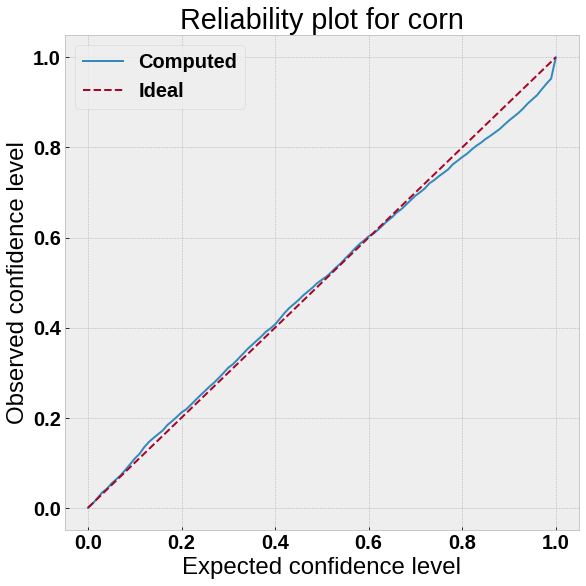

In [23]:
df = evaluate(model, data['X_test'], data['y_test'], data['y_scaler'])
plot_reliability(df, crop, data['y_scaler'], step=.01)

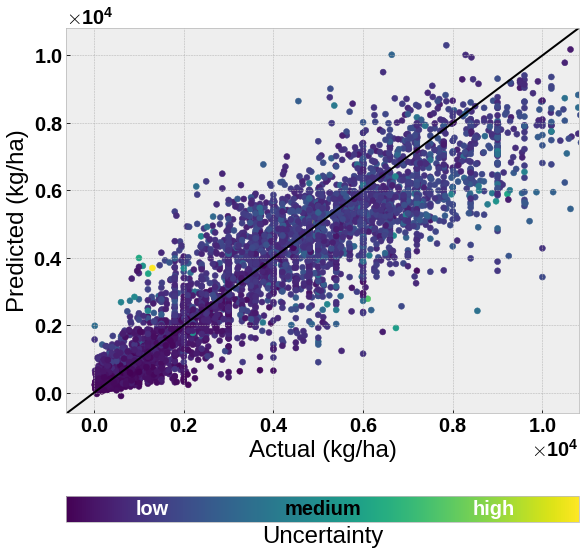

In [24]:
plot_scatter(df, crop, data['y_scaler'])

In [25]:
study.best_trial.params

{'entropy': 0.3451493310472916, 'noise': 0.09835271852699944}

In [26]:
df.to_csv('corn-yield.csv', index=False)